## Task: AllLife Credit Card Customer Segmentation 

#### Background:

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.


#### Objective: 
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank. 


#### Key Questions:
- How many different segments of customers are there?
- How are these segments different from each other?
- What are your recommendations to the bank on how to better market to and service these customers?

#### Data Description:
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre. 



#### Steps to follow:
- Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. 
- Perform EDA and take insights out. pts 1 and 2 – (5)
- Create visualizations to explore data and present the insights. (5)
- Properly comment on the codes and provide explanations of the steps taken in the notebook. (5)
- Execute hierarchical and K-means clustering (with different linkages) and do relevant visualisations (elbow plot, dendrograms etc) (10)
- Perform a silhouette analysis. (5)

Import Libraries:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from som import SOM

Load and review data:

In [2]:
df = pd.read_csv("Credit Card Customer Data.csv")
print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
df.head()

This dataset has 660 rows, and 7 columns


Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

'Sl_No' and 'Customer Key' are IDs and then I can drop them because not important for the analysis.

In [3]:
df.drop(['Sl_No','Customer Key'], axis=1, inplace=True)
df.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0            100000                   2                  1   
1             50000                   3                  0   
2             50000                   7                  1   
3             30000                   5                  1   
4            100000                   6                  0   

   Total_visits_online  Total_calls_made  
0                    1                 0  
1                   10                 9  
2                    3                 4  
3                    1                 4  
4                   12                 3

I found a function to reduce the memory size without loosing any information:

https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

In [4]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

df, NAlist = reduce_mem_usage(df)

Memory usage of properties dataframe is : 0.025299072265625  MB
******************************
Column:  Avg_Credit_Limit
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  Total_Credit_Cards
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  Total_visits_bank
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  Total_visits_online
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  Total_calls_made
dtype before:  int64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.005157470703125  MB
This is  20.386007237635706 % of the initial size


Checking for nulls and data types:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
Avg_Credit_Limit       660 non-null uint32
Total_Credit_Cards     660 non-null uint8
Total_visits_bank      660 non-null uint8
Total_visits_online    660 non-null uint8
Total_calls_made       660 non-null uint8
dtypes: uint32(1), uint8(4)
memory usage: 5.3 KB


All the arributes are numerical and none of the value is NaN. Let's check the statistics summary of the dataframe:

In [6]:
df.describe().transpose()

count          mean           std     min      25%  \
Avg_Credit_Limit     660.0  34574.242424  37625.487804  3000.0  10000.0   
Total_Credit_Cards   660.0      4.706061      2.167835     1.0      3.0   
Total_visits_bank    660.0      2.403030      1.631813     0.0      1.0   
Total_visits_online  660.0      2.606061      2.935724     0.0      1.0   
Total_calls_made     660.0      3.583333      2.865317     0.0      1.0   

                         50%      75%       max  
Avg_Credit_Limit     18000.0  48000.0  200000.0  
Total_Credit_Cards       5.0      6.0      10.0  
Total_visits_bank        2.0      4.0       5.0  
Total_visits_online      2.0      4.0      15.0  
Total_calls_made         3.0      5.0      10.0

## Univariate analysis:

Let's visualize the boxplot distributions for each features in the dataset:

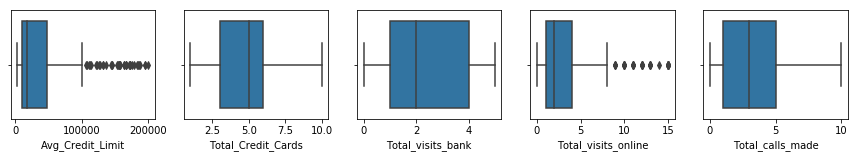

In [7]:
feature, axs = plt.subplots(ncols = 5, figsize=(15, 2))

for i in range(0,len(df.columns)):
    sns.boxplot(x=df.iloc[:,i], ax=axs[i])

'Avg_Credit_limit' and 'Total_visits_online' are skewd to the left with a long tail to the right. I will not cap the outliers since all the values are in an accettable range.

## Multivariate analysis:

Identify Correlation in data:

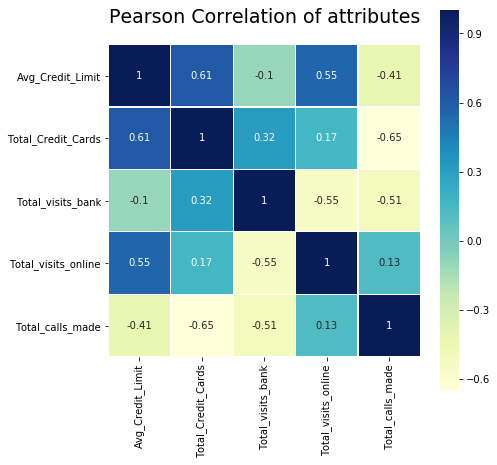

In [8]:
colormap = plt.cm.viridis
plt.figure(figsize=(7,7))
plt.title('Pearson Correlation of attributes', y=1.05, size=19)
sns.heatmap(df.corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap='YlGnBu', 
            linecolor='white',
            annot=True)

#### Considerations:
- There is a strong positive correlation between 'Total_Credit_Cards' and 'Aveg_Credit_imit'.
- There is a strong negative correlation between 'Total_Credit_Cards' and 'Total_calls made'.

## Scaling

Since clustering analysis is sensitive to different scales of the data, I am going to standardize all the columns in the dataset:

In [9]:
df = df.apply(zscore)
df.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  
0            -0.547490         -1.251537  
1             2.520519          1.891859  
2             0.134290          0.145528  
3            -0.547490          0.145528  
4             3.202298         -0.203739

## Unsupervised Learning: K-means Clustering Analysis

I will start by checking if there are any clusters within the data and choosing the optimal number of clusters with the elbow method:

Text(0.5, 1.0, 'Selecting the optimal k with the Elbow Method')

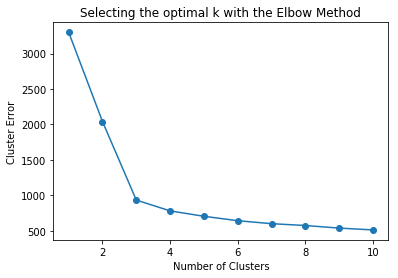

In [10]:
cluster_errors = []
for num_clusters in range(1,11):
    model = KMeans(num_clusters)
    model.fit(df)
    cluster_errors.append(model.inertia_)
plt.plot(range(1,11), cluster_errors, marker = "o" )
plt.ylabel('Cluster Error')
plt.xlabel('Number of Clusters')
plt.title('Selecting the optimal k with the Elbow Method')

I can clearly see that the optima number of k is 3:

In [11]:
final_model=KMeans(3)
final_model.fit(df)
df['Group'] = final_model.predict(df)
print("Groups Assigned : \n")
df.head()

Groups Assigned : 



Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  Group  
0            -0.547490         -1.251537      0  
1             2.520519          1.891859      2  
2             0.134290          0.145528      0  
3            -0.547490          0.145528      0  
4             3.202298         -0.203739      1

Let's first analyze the means of the columns by groups:

In [12]:
df_group = df.groupby(['Group'])
df_group.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0             -0.021062            0.373690           0.666395   
1              2.831764            1.862226          -1.105763   
2             -0.595796           -1.059623          -0.901518   

       Total_visits_online  Total_calls_made  
Group                                         
0                -0.553672         -0.553005  
1                 2.827319         -0.874330  
2                 0.322997          1.148109

I can also analyze the distribution of the data among the groups. One of the most informative visual tool is boxplot:

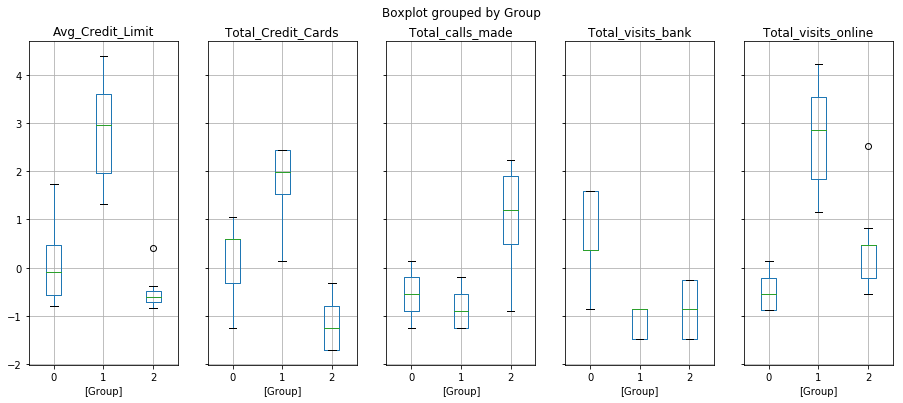

In [13]:
boxplot = df.boxplot(by='Group', layout=(1,5), figsize=(15,6))

There are 2 outliers, one in 'Avg_Credit_Limit' and another in 'Total_visits_online'. I can also check them in the pairplot:

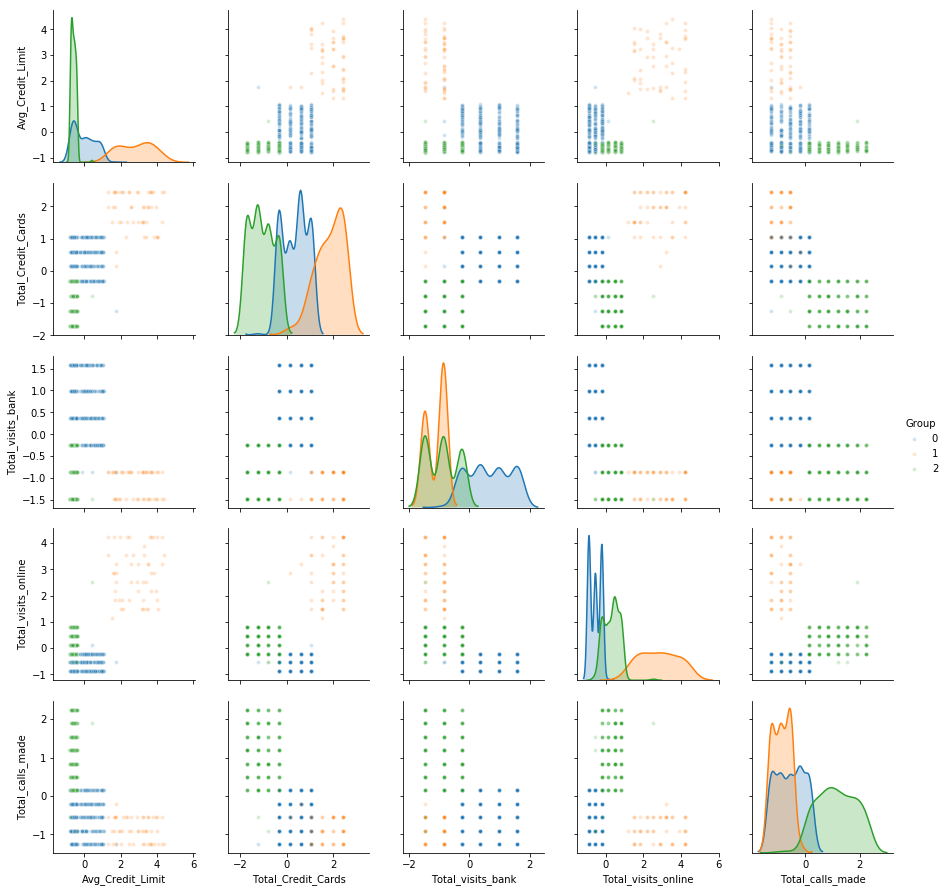

In [14]:
pairplot = sns.pairplot(df,
                        diag_kind='kde',
                        hue='Group',
                        hue_order=[0,1,2], 
                        plot_kws={"s": 15,'alpha': 0.2},
                        vars=list(df.iloc[:,:-1].columns))

We can see the outliers also in the visualization above. The plot 'Total_visits_online' joined with 'Total_calls_made' is very representative because I can distinguish properly the 3 cluisters.

Unfortunatelly I can't plot a dataset with a dimension higher than 3. I am going to apply feature extraction. 

## PCA: Principal Component Analysis

4 Principal Components are needed to exaplin 95% of the variance


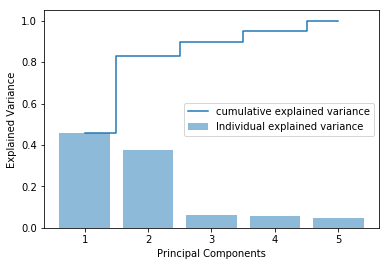

In [15]:
pca = PCA()
pca.fit(df.iloc[:,:-1])
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
cum_var_exp = cumsum[cumsum<0.95]
plt.step(range(1, cumsum.shape[0]+1),cumsum, where= 'mid', label='cumulative explained variance')
plt.bar(range(1, cumsum.shape[0]+1), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
print('%d Principal Components are needed to exaplin 95%% of the variance' %d)
plt.show()

The optimal number of principal components would be 4, but I can't plot more than 3 dimensions:

In [16]:
pca3 = PCA(n_components=3)
df_3 = pca3.fit_transform(df.iloc[:,:-1])
df_3 = pd.DataFrame(df_3, columns=['PC 1','PC 2','PC 3'])
df_3.head()

PC 1      PC 2      PC 3
0  0.501291  0.524829  1.895862
1 -1.459560  3.105588 -0.906802
2  0.525795  0.823979  0.089030
3 -0.362294  0.128123  0.558215
4  1.266228  3.668708 -0.099999

In K-Means, we do what is called “hard labeling”, where we simply add the label of the maximum probability. However, certain data points that exist at the boundary of clusters may simply have similar probabilities of being on either clusters. In such circumstances, we look at all the probabilities instead of the max probability. This is known as “soft labeling”.

## Gaussian Mixture Model

Text(0.5, 0.92, 'Gaussian Mixture Model')

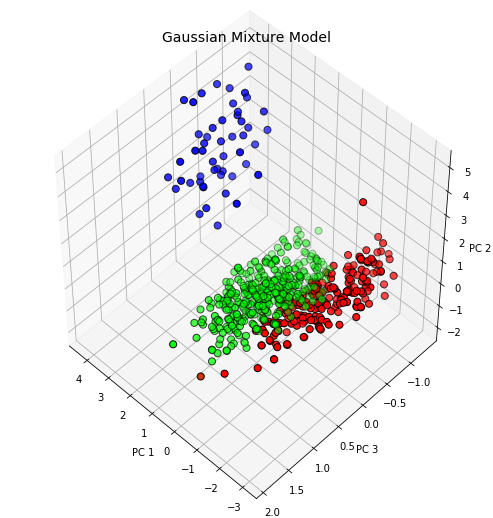

In [17]:
df_3 = np.array(df_3)
gmm = GaussianMixture(n_components=3)
gmm.fit(df_3)
proba_lists = gmm.predict_proba(df_3)
colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(df_3[:, 0], df_3[:, 2], df_3[:, 1],
          c=colored_tuples, edgecolor="k", s=50)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 3')
ax.set_zlabel('PC 2')
plt.title("Gaussian Mixture Model", fontsize=14)

There is one cluster clearly separated by the other 2. Let's perform an hierarchical clustering analysis to analyze this in more details, using the dendrogram. Cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram. Closer it is to 1, the better is the clustering.

In [18]:
cophenets = []
methods = ['single','complete','average','weighted','centroid','median','ward']

for m in methods:
    Z = linkage(df.iloc[:,:-1], metric='euclidean', method=m)
    c, coph_dists = cophenet(Z , pdist(df.iloc[:,:-1]))
    cophenets.append(c)
    
results = pd.concat([pd.DataFrame(methods),pd.DataFrame(cophenets)], axis=1)
results.columns = ['Methods','Cophenet']
results = results.sort_values('Cophenet',ascending=False)
results.reset_index(inplace=True,drop=True)
results

Methods  Cophenet
0   average  0.897708
1  centroid  0.893939
2    median  0.889380
3  weighted  0.886175
4  complete  0.859973
5      ward  0.741516
6    single  0.739122

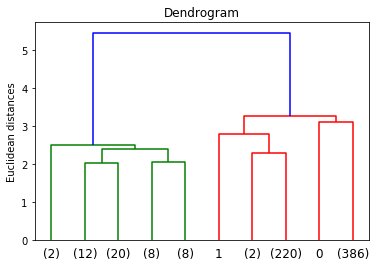

In [19]:
dendrogram = sch.dendrogram(sch.linkage(df.iloc[:,:-1], method = 'average'), truncate_mode='lastp', p=10)
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

The gap between 2 and 3 clusters is much bigger compared to 3 and 4 clusters.

## Silhouette analysis 

I could also extract the 2 pricipal components and perform the Silhouette analysis. This can be used to evaluate the unsupervised analysis and then to choose an optimal value of clusters. It mesures how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

This measure has a range of [-1, 1]. When the coeffiecient near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.56
For n_clusters = 3 The average silhouette_score is : 0.68
For n_clusters = 4 The average silhouette_score is : 0.47
For n_clusters = 5 The average silhouette_score is : 0.38
For n_clusters = 6 The average silhouette_score is : 0.39


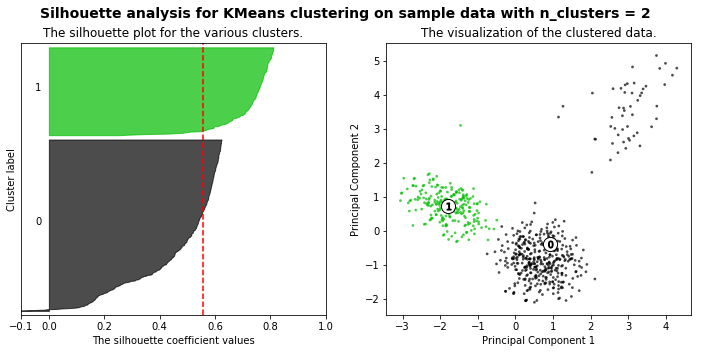

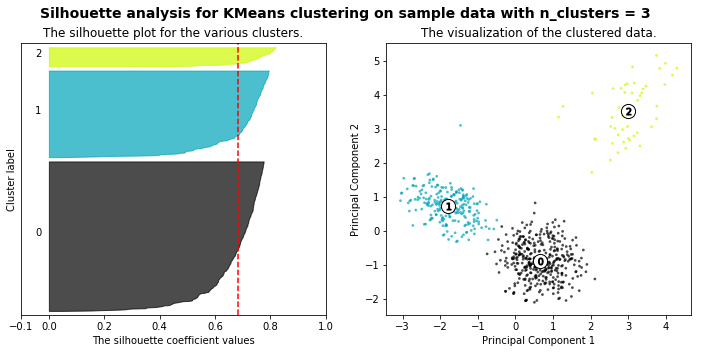

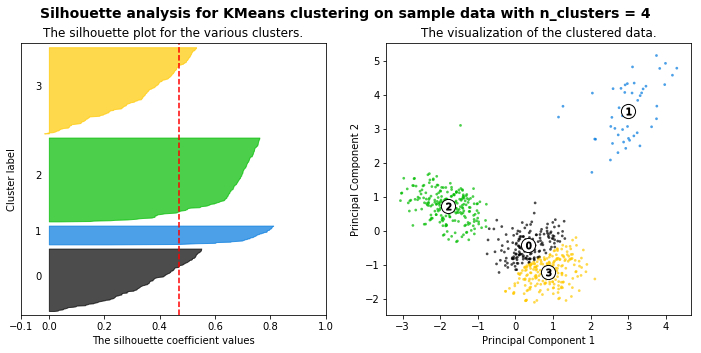

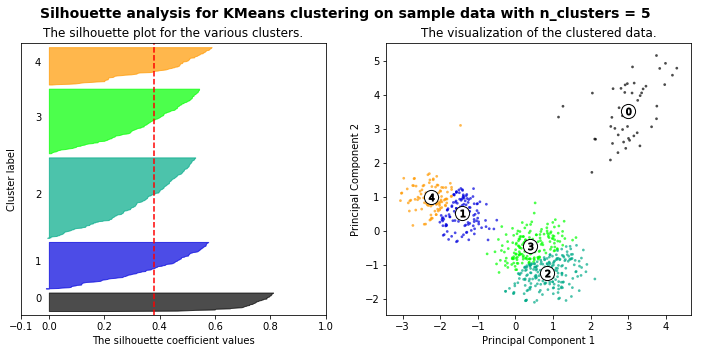

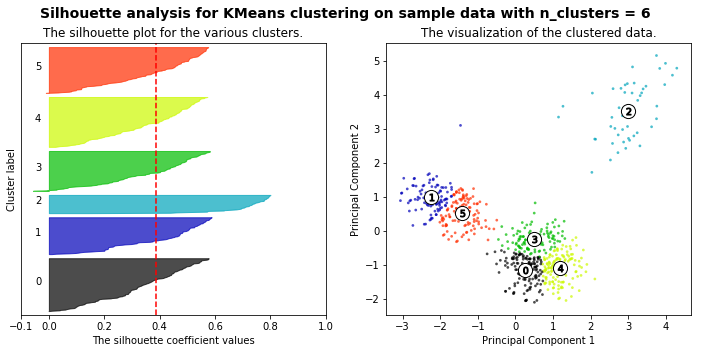

In [20]:
pca2 = PCA(n_components=2)
df_2 = pca2.fit_transform(df.iloc[:,:-1])
X = np.array(df_2)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples. 
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round((silhouette_avg),2))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Principal Component 1")
    ax2.set_ylabel("Principal Component 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The optimal number of clusters is 2.

## Corgie vehicle data PCA

#### Background
Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

#### Problem Statement
The purpose of the case study is to classify a given silhouette as one of four different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.
The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

#### The points distribution for this case is as follows:
- Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)
- Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)
- Use PCA from scikit learn and elbow plot to find out reduced number of dimension (which covers more than 95% of the variance) (10 points)
- Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyper parameters and do cross validation to find the accuracy. (10 points)


In [21]:
df = pd.read_csv("vehicle.csv")
print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
df.head()

This dataset has 846 rows, and 19 columns


compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

Reduce the memory size without loosing any information and fill the NaN values with the median of the column:

In [22]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(props[col].median(),inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

df, NAlist = reduce_mem_usage(df)

Memory usage of properties dataframe is : 0.1227569580078125  MB
******************************
Column:  compactness
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  circularity
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  distance_circularity
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  radius_ratio
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  pr.axis_aspect_ratio
dtype before:  float64
dtype after:  uint8
******************************
******************************
Column:  max.length_aspect_ratio
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  scatter_ratio
dtype before:  float64
dtype after:  uint16
******************************
**********************

Checking for nulls and data types:

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null uint8
circularity                    846 non-null uint8
distance_circularity           846 non-null uint8
radius_ratio                   846 non-null uint16
pr.axis_aspect_ratio           846 non-null uint8
max.length_aspect_ratio        846 non-null uint8
scatter_ratio                  846 non-null uint16
elongatedness                  846 non-null uint8
pr.axis_rectangularity         846 non-null uint8
max.length_rectangularity      846 non-null uint8
scaled_variance                846 non-null uint16
scaled_variance.1              846 non-null float32
scaled_radius_of_gyration      846 non-null float32
scaled_radius_of_gyration.1    846 non-null float32
skewness_about                 846 non-null uint8
skewness_about.1               846 non-null uint8
skewness_about.2               846 non-null uint8
hollows_ratio                  846 n

Statistics summary of the dataframe:

In [24]:
df.describe().transpose()

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  846.0   44.823877    6.134272   33.0   40.00   
distance_circularity         846.0   82.100473   15.741569   40.0   70.00   
radius_ratio                 846.0  168.874704   33.401356  104.0  141.00   
pr.axis_aspect_ratio         846.0   61.677305    7.882188   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                846.0  168.887707   33.197710  112.0  147.00   
elongatedness                846.0   40.936170    7.811882   26.0   33.00   
pr.axis_rectangularity       846.0   20.580378    2.588558   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              846.0  188.596927   31.360427  130.0  167.00   
scaled_variance.1            846.0  439.314423  176.496307  184.0  318.25   
scaled_radius_of_gyration    846.0  174.706863   32.546284  109.0  149.00   
scaled_radius_of_gyration.1  846.0   72.443260    7.468725   59.0   67.00   
skewness_about               846.0    6.361702    4.903244    0.0    2.00   
skewness_about.1             846.0   12.600473    8.930962    0.0    5.00   
skewness_about.2             846.0  188.918440    6.152247  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   

                               50%     75%     max  
compactness                   93.0  100.00   119.0  
circularity                   44.0   49.00    59.0  
distance_circularity          80.0   98.00   112.0  
radius_ratio                 167.0  195.00   333.0  
pr.axis_aspect_ratio          61.0   65.00   138.0  
max.length_aspect_ratio        8.0   10.00    55.0  
scatter_ratio                157.0  198.00   265.0  
elongatedness                 43.0   46.00    61.0  
pr.axis_rectangularity        20.0   23.00    29.0  
max.length_rectangularity    146.0  159.00   188.0  
scaled_variance              179.0  217.00   320.0  
scaled_variance.1            363.5  586.75  1018.0  
scaled_radius_of_gyration    173.5  198.00   268.0  
scaled_radius_of_gyration.1   71.5   75.00   135.0  
skewness_about                 6.0    9.00    22.0  
skewness_about.1              11.0   19.00    41.0  
skewness_about.2             188.0  193.00   206.0  
hollows_ratio                197.0  201.00   211.0

There are no NaNs and only the target variable is an object. I have to encode this column:

In [25]:
df.rename(columns={'class':'Target'}, inplace=True)
encoding = {'Target': {'car': 0, 'van': 1, 'bus': 2}}
df.replace(encoding, inplace=True)
df.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95           48                    83           178   
1           91           41                    84           141   
2          104           50                   106           209   
3           93           41                    82           159   
4           85           44                    70           205   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                    72                       10            162   
1                    57                        9            149   
2                    66                       10            207   
3                    63                        9            144   
4                   103                       52            149   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0             42                      20                        159   
1             45                      19                        143   
2             32                      23                        158   
3             46                      19                        143   
4             45                      19                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0              176              379.0                      184.0   
1              170              330.0                      158.0   
2              223              635.0                      220.0   
3              160              309.0                      127.0   
4              241              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0               6                16   
1                         72.0               9                14   
2                         73.0              14                 9   
3                         63.0               6                10   
4                        127.0               9                11   

   skewness_about.2  hollows_ratio  Target  
0               187            197       1  
1               189            199       1  
2               188            196       0  
3               199            207       1  
4               180            183       2

Shuffle the dataset because some learning algorithms are sensitive to the order of the training instances. This will also guarantee that all cross-validation folds will be similar.

In [26]:
df = df.sample(frac=1,random_state=1)
df.reset_index(inplace=True,drop=True)

#### Scaling the data: normalization
Since many machine learning techniques are sensitive to different scales of the data, I am going to normalize all the indipendend variables in the dataset.

In [27]:
X = df.iloc[:,:-1]
y = df['Target']
columns = X.columns.to_list()
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = columns
extra_cols = df.iloc[:,-1:]
df = pd.concat([pd.DataFrame(X),pd.DataFrame(extra_cols)],axis=1)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


compactness  circularity  distance_circularity  radius_ratio  \
0     0.369565     0.500000              0.486111      0.126638   
1     0.782609     0.730769              0.763889      0.371179   
2     0.586957     0.307692              0.486111      0.441048   
3     0.586957     0.615385              0.555556      0.445415   
4     0.478261     0.346154              0.777778      0.406114   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0              0.087912                 0.169811       0.313725   
1              0.120879                 0.037736       0.751634   
2              0.263736                 0.056604       0.418301   
3              0.252747                 0.075472       0.464052   
4              0.197802                 0.132075       0.431373   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0       0.485714                0.250000                   0.614286   
1       0.085714                0.666667                   0.571429   
2       0.285714                0.333333                   0.285714   
3       0.257143                0.333333                   0.542857   
4       0.314286                0.333333                   0.328571   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0         0.226316           0.221823                   0.389937   
1         0.694737           0.709832                   0.679245   
2         0.389474           0.353717                   0.264151   
3         0.400000           0.399281                   0.559748   
4         0.363158           0.347722                   0.251572   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                     0.236842        0.000000          0.390244   
1                     0.302632        0.000000          0.463415   
2                     0.171053        0.318182          0.463415   
3                     0.184211        0.136364          0.317073   
4                     0.105263        0.045455          0.707317   

   skewness_about.2  hollows_ratio  Target  
0          0.200000       0.366667       1  
1          0.366667       0.166667       2  
2          0.700000       0.533333       2  
3          0.733333       0.600000       2  
4          0.566667       0.633333       0

Now let's visualize the correlation of the data:

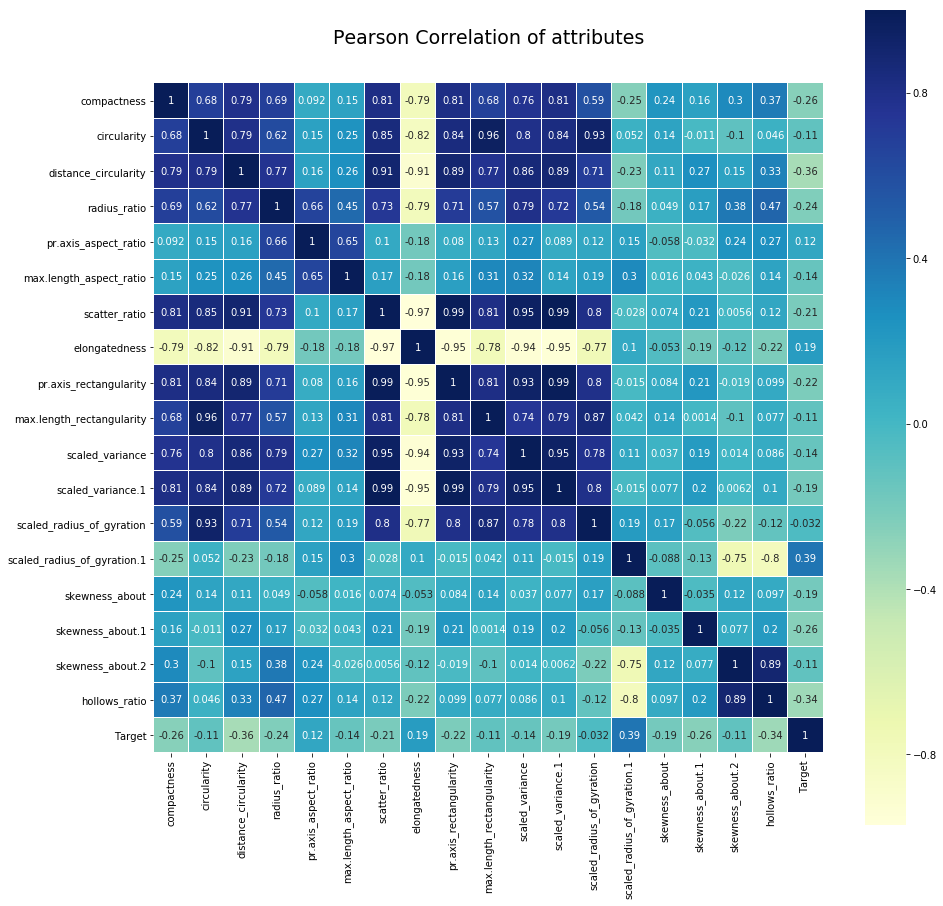

In [29]:
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of attributes', y=1.05, size=19)
heatmap = sns.heatmap(df.corr(),
                      linewidths=0.1,
                      vmax=1.0, 
                      square=True, 
                      cmap='YlGnBu', 
                      linecolor='white',
                      annot=True)

I can also check the pairplot: you can zoom the chart by double-clicking on it.

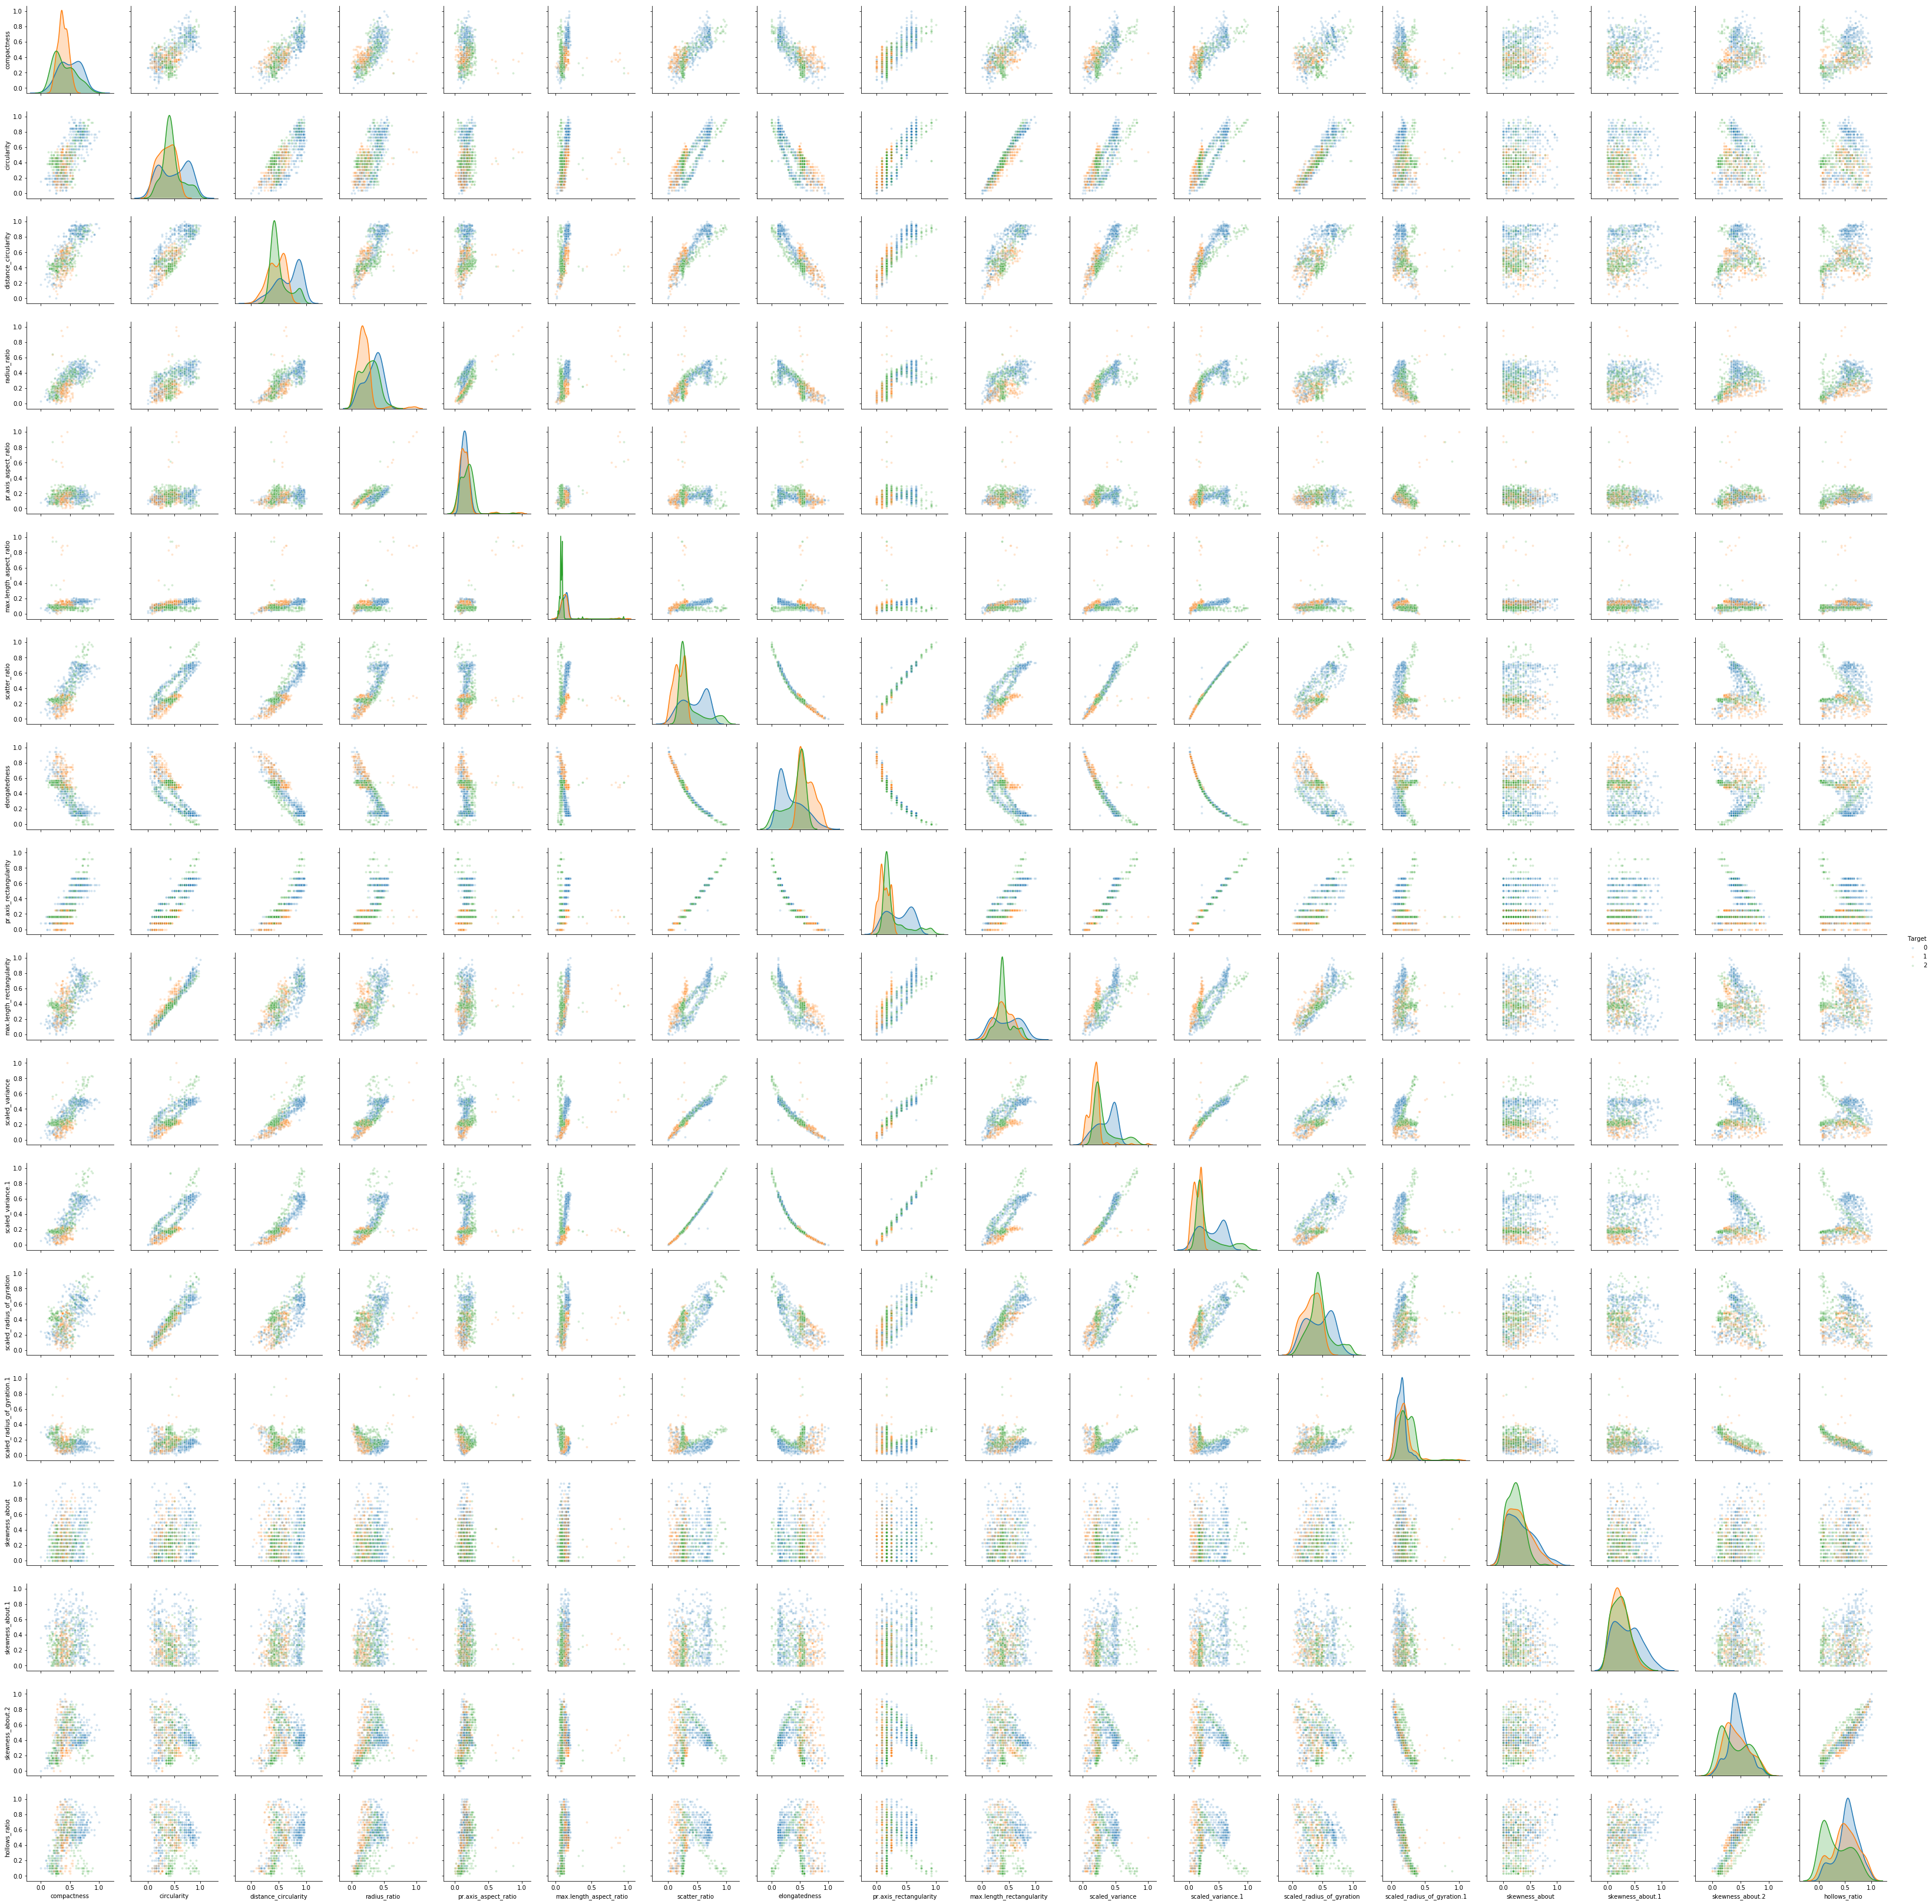

In [30]:
pairplot = sns.pairplot(df,
                        diag_kind='kde',
                        hue='Target',
                        hue_order=[0,1,2], 
                        plot_kws={"s": 15,'alpha': 0.2},
                        vars=list(df.iloc[:,:-1].columns))

This is what I can notice from the previous 2 plots:
- A) There are many leverage points
- B) There are many features higly positive or negative correlated


SOLUTIONS A:
- 1) Capping the ouliers analysing 1 feature at the time
- 2) Capping the ouliers analysing 2 features at the time
- 3) Capping the ouliers analysing the distributions of each feature by the groups created in the unsupervised analysis

SOLUTIONS B:
- 1) Keep only 1 feature of all the pairs higly correlated
- 2) Perform a L1 regularization (Lasso)
- 3) Apply a feature extraction technique to reduce the dimensionality of the dataset

I chose A.3 and B.3 solutions (see below).

## Spliting the data in train and test set
I am going to use 70% of data for training and 30% for testing

In [31]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
for train_index, test_index in split.split(df, df['Target']):
    train = df.loc[train_index]
    test = df.loc[test_index]

X_train = train.drop(['Target'],axis=1)
X_test = test.drop(['Target'],axis=1)
y_train = train['Target']
y_test = test['Target']

print('%.0f records (%.0f%%) are used for training \n%.0f records (%.0f%%) are used for testing' % (len(train), (100*len(train)/len(df)), len(test), (100*len(test)/len(df))))

592 records (70%) are used for training 
254 records (30%) are used for testing


Check 'Target' ratio of the split data. This is a sanity check to assure a correct stratified sampling of the 3 groups: we would like to have similar ratio in the original dataset, training and test set.

In [32]:
df_ratio = pd.DataFrame(round(df.groupby(['Target']).count().iloc[:,0]/len(df),4))
train_ratio = pd.DataFrame(round(train.groupby(['Target']).count().iloc[:,0]/len(train),4))
test_ratio = pd.DataFrame(round(test.groupby(['Target']).count().iloc[:,0]/len(test),4))
Stratified_split = pd.concat([df_ratio,train_ratio,test_ratio],axis=1)
Stratified_split.columns = ['df','train','test']
Stratified_split

df   train    test
Target                        
0       0.5071  0.5068  0.5079
1       0.2352  0.2348  0.2362
2       0.2577  0.2584  0.2559

## Randomized search with cross-validation for hyperparameters tuning:

In [33]:
def tuning(model,parameters,iteration=50,n_folds=10,X_train=X_train,y_train=y_train):
    start1=datetime.now()
    randomCV1 = RandomizedSearchCV(model,
                                   param_distributions=parameters,
                                   n_iter=5,
                                   cv=n_folds,
                                   random_state=1)
    randomCV1.fit(X_train, y_train)
    stop1=datetime.now()
    execution_time1 = stop1-start1
    print('Expected execution time is about',iteration*execution_time1/5,'\n')
    
    start=datetime.now()
    randomCV = RandomizedSearchCV(model,
                                  param_distributions=parameters,
                                  n_iter=iteration,
                                  cv=n_folds,
                                  random_state=1)
    randomCV.fit(X_train, y_train)
    stop=datetime.now()
    execution_time = stop-start
    print('Execution time =',execution_time,'\n')
    print('The best combination of hyperparameters is:\n\n',randomCV.best_params_)

#### SVM
Instead of using grid search, I am going to use RandomizedSearchCV. It allows me to have much more control on the time spent on the tuning and usually it leads to better results.

In [34]:
param_dist = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'C': np.linspace(0.1,10,100),
              'gamma': np.linspace(0.1,10,100)}
tuning(SVC(decision_function_shape='ovo', random_state=1), param_dist)

Expected execution time is about 0:00:11.681900 

Execution time = 0:00:10.179391 

The best combination of hyperparameters is:

 {'kernel': 'poly', 'gamma': 4.1, 'C': 0.7000000000000001}


Saving SVM hyperparameters:

In [35]:
svm_hyperparameters = {'kernel': 'poly', 
                       'gamma': 4.1, 
                       'C': 0.7000000000000001}

svm = SVC(kernel=svm_hyperparameters.get('kernel'),
          C=svm_hyperparameters.get('C'),
          gamma=svm_hyperparameters.get('gamma'),
          decision_function_shape='ovo',
          random_state=1)

Since this multiclass classification supervised problem is only sligthly unbalanced, I can use the accuracy to evaluate the model.

              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98       129
     class 1       0.97      0.98      0.98        60
     class 2       0.98      0.95      0.97        65

   micro avg       0.98      0.98      0.98       254
   macro avg       0.98      0.97      0.97       254
weighted avg       0.98      0.98      0.98       254



ACCURACY = 97.6 %


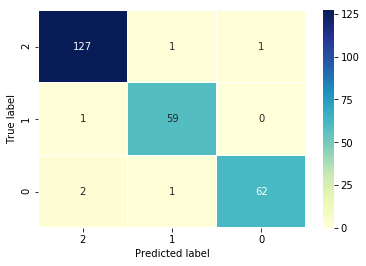

In [37]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))
a = round(metrics.accuracy_score(y_test, y_pred),3)
print('\n\nACCURACY =',round((a*100),2),'%')
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True,  
            fmt='.0f', 
            xticklabels=["2", "1", "0"] , 
            yticklabels=["2", "1", "0"], 
            linewidths=0.1, 
            linecolor='white',
            cmap='YlGnBu')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### LIGHT GBM

I am going to try another model.

In [38]:
param_dist = {'application': ['multiclass'],
              'feature_fraction': np.linspace(0.3,1,8),
              'erbose_eval': [False,True],
              'booster': ['dart','gbdt'],
              'num_leaves': sp_randint(2, X_train.shape[1]+1),
              'max_depth': sp_randint(1, X_train.shape[1]+1),
              'max_bin': sp_randint(10, 200),
              'n_estimators': sp_randint(10, 500),
              'learning_rate': np.linspace(0.01,1,30)}
tuning(LGBMClassifier(random_state=1),param_dist)

Expected execution time is about 0:01:39.685270 

Execution time = 0:01:41.775557 

The best combination of hyperparameters is:

 {'application': 'multiclass', 'booster': 'dart', 'erbose_eval': True, 'feature_fraction': 0.6, 'learning_rate': 0.5220689655172415, 'max_bin': 131, 'max_depth': 9, 'n_estimators': 40, 'num_leaves': 9}


Saving Light GBM hyperparameters:

In [39]:
lgbm_hyperparameters = {'application': 'multiclass', 
                        'booster': 'dart', 
                        'erbose_eval': True, 
                        'feature_fraction': 0.6, 
                        'learning_rate': 0.5220689655172415, 
                        'max_bin': 131, 
                        'max_depth': 9, 
                        'n_estimators': 40, 
                        'num_leaves': 9}

lgbm = LGBMClassifier(application=lgbm_hyperparameters.get('application'),
                      objective=lgbm_hyperparameters.get('objective'),
                      is_unbalance=lgbm_hyperparameters.get('is_unbalance'),
                      feature_fraction=lgbm_hyperparameters.get('feature_fraction'),
                      bagging_fraction=lgbm_hyperparameters.get('bagging_fraction'),
                      bagging_freq=lgbm_hyperparameters.get('bagging_freq'),
                      verbose=lgbm_hyperparameters.get('verbose'),
                      booster=lgbm_hyperparameters.get('booster'),                  
                      erbose_eval=lgbm_hyperparameters.get('erbose_eval'),
                      num_leaves=lgbm_hyperparameters.get('num_leaves'),
                      max_depth=lgbm_hyperparameters.get('max_depth'),
                      max_bin=lgbm_hyperparameters.get('max_bin'),                      
                      n_estimators=lgbm_hyperparameters.get('n_estimators'),     
                      learning_rate=lgbm_hyperparameters.get('learning_rate'), 
                      random_state=1)

Now I can evaluate the model:

              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97       129
     class 1       0.95      0.92      0.93        60
     class 2       0.98      0.98      0.98        65

   micro avg       0.96      0.96      0.96       254
   macro avg       0.96      0.96      0.96       254
weighted avg       0.96      0.96      0.96       254



ACCURACY = 96.5 %


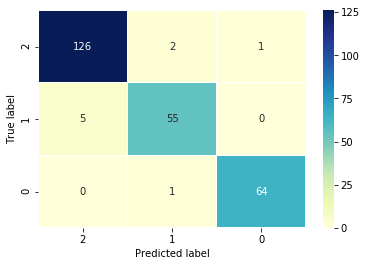

In [40]:
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))
a = round(metrics.accuracy_score(y_test, y_pred),3)
print('\n\nACCURACY =',round((a*100),2),'%')
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True,  
            fmt='.0f', 
            xticklabels=["2", "1", "0"] , 
            yticklabels=["2", "1", "0"], 
            linewidths=0.1, 
            linecolor='white',
            cmap='YlGnBu')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The performance on the test-set are great and the models are relatevily fast: this is already a very good results. I could try to remove the outliers.

## Unsupervised Learning: K-means Clustering Analysis

I will start by checking if there are any clusters within the data:

In [41]:
cluster_range = range(1,11) 
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters, n_init=5)
  clusters.fit(train)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append(clusters.inertia_ )
clusters_df = pd.DataFrame({"num_clusters":cluster_range, "cluster_errors": cluster_errors})
clusters_df

num_clusters  cluster_errors
0             1      810.374160
1             2      437.733605
2             3      315.479574
3             4      239.832645
4             5      198.004134
5             6      176.685477
6             7      155.994718
7             8      143.266457
8             9      134.589870
9            10      127.057848

Elbow plot:

Text(0.5, 0, 'Number of Clusters')

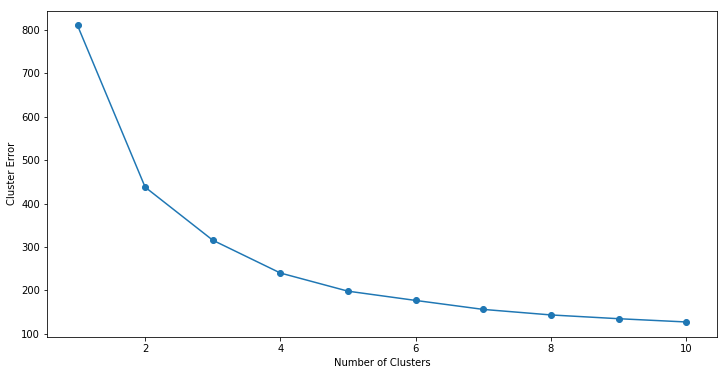

In [42]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.ylabel('Cluster Error')
plt.xlabel('Number of Clusters')

There is the the bend at 4, so let us create 4 custers.

In [43]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(train)
train['group'] = kmeans.predict(train)

## Following approach:

I need to be very careful to not add any bias to the analysis. This is why I will clip the outliers only for the training set to keep the test set unbiased. Let's visualize the boxplot distributions by groups per each features for the training set:

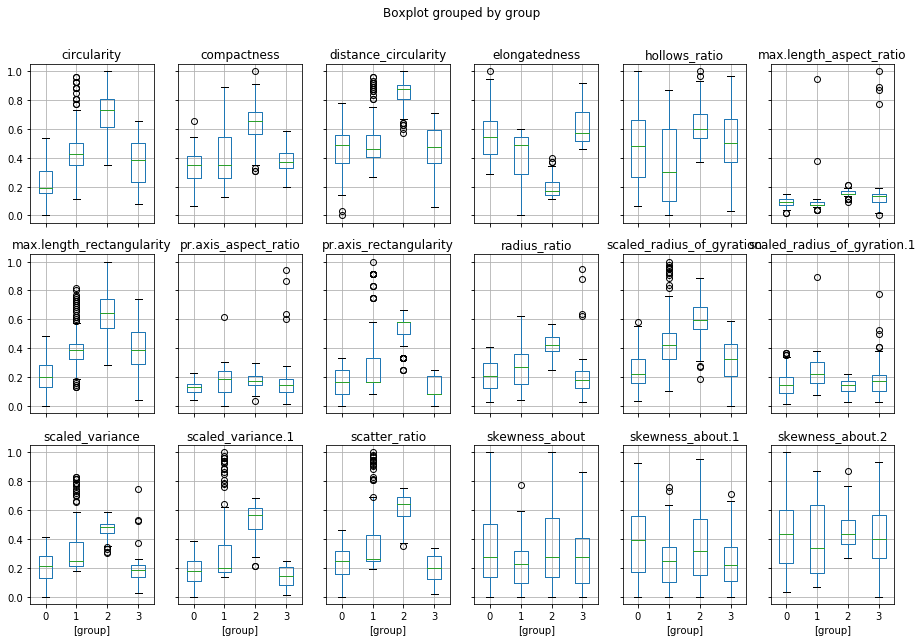

In [44]:
boxplots = train.drop(['Target'],axis=1).boxplot(by='group',  layout=(3,6), figsize=(15, 10))

There are many outliers. I am going to cap them:

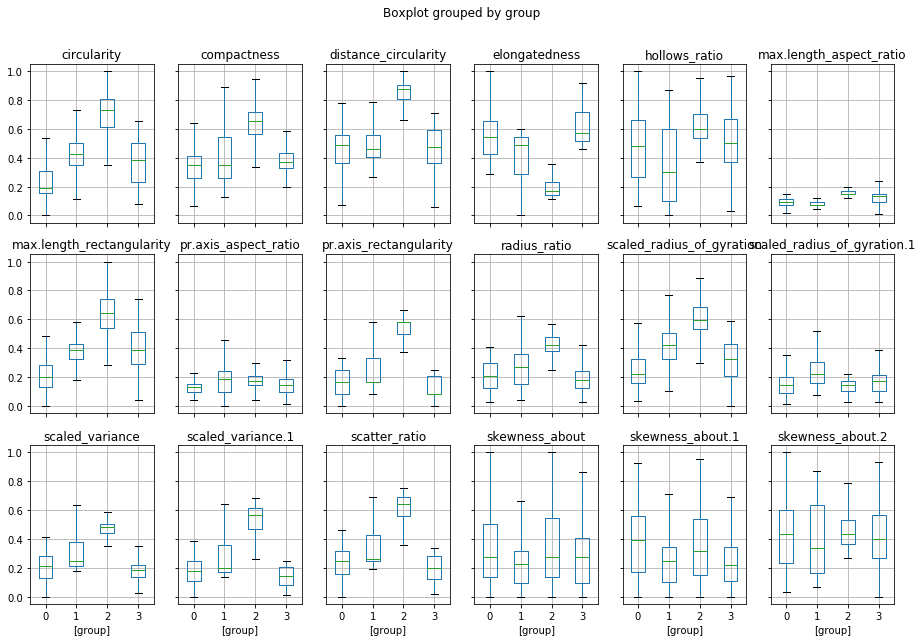

In [45]:
groups = train['group'].unique()
fratures = train.columns.to_list()
fratures = fratures[:-2]
train_outliers = train
for f in fratures:
    for n in groups:
        Q1 = np.percentile(train_outliers[train_outliers['group']==n][f],25)
        Q3 = np.percentile(train_outliers[train_outliers['group']==n][f],75)
        train_outliers.loc[(train_outliers['group']==n) & (train_outliers[f]>Q3+1.5*(Q3-Q1)),f] = Q3+1.5*(Q3-Q1)
        train_outliers.loc[(train_outliers['group']==n) & (train_outliers[f]<Q1-1.5*(Q3-Q1)),f] = Q1-1.5*(Q3-Q1)
        
boxplots = train_outliers.drop(['Target'],axis=1).boxplot(by='group',  layout=(3,6), figsize=(15, 10))

All good! Now I am finally ready create the the training set with the outliers capped.

In [47]:
X_train_outliers = train_outliers.drop(['Target','group'],axis=1)

Now I can evaluate the SVM model with the outliers capped:

              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98       129
     class 1       0.94      0.98      0.96        60
     class 2       0.97      0.92      0.94        65

   micro avg       0.96      0.96      0.96       254
   macro avg       0.96      0.96      0.96       254
weighted avg       0.96      0.96      0.96       254



ACCURACY = 96.5 %


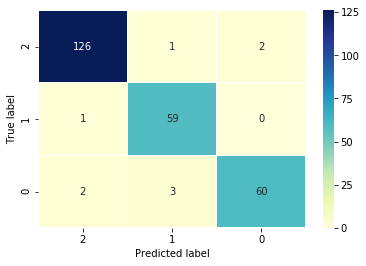

In [48]:
svm.fit(X_train_outliers, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))
a = round(metrics.accuracy_score(y_test, y_pred),3)
print('\n\nACCURACY =',round((a*100),2),'%')
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True,  
            fmt='.0f', 
            xticklabels=["2", "1", "0"] , 
            yticklabels=["2", "1", "0"], 
            linewidths=0.1, 
            linecolor='white',
            cmap='YlGnBu')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Removing the outliers didn't help.

There are many features that are highly positive or negative correlated. Instead of dropping them, I could apply a technique of feature extraction.

Below are listed 3 techniques:
- PCA: Principal Component Analysis identifies the combination of components (directions in the feature space) that account for the most variance in the data.
- t-SNE: T-Distributed Stochastic Neighbouring Entities is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. It could potentially lead to better data separation/visualization, because unlike PCA it preserves the local structure of data points.
- SOMs: Self Organised Maps. It a type of artificial neural network (ANN) that is trained using unsupervised learning to produce a low-dimensional (typically two-dimensional), discretized representation of the input space of the training samples, called a map, and is therefore a method to do dimensionality reduction. Self-organizing maps differ from other artificial neural networks as they apply competitive learning as opposed to error-correction learning (such as backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

I am going to apply these techniques with only 2 dimensions in order create vizualisation to compare their results:

## PCA & t-SNE:

Text(0.5, 1.0, 't-SNE')

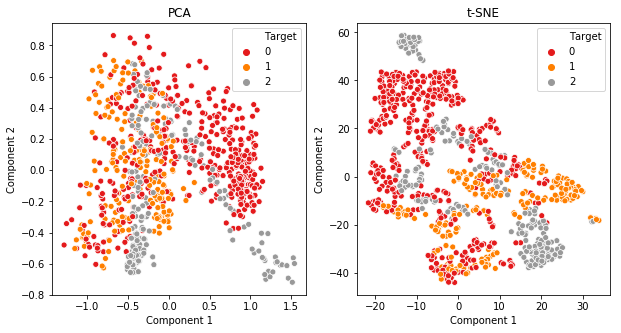

In [50]:
X = df.iloc[:,:-1]

plt.figure(figsize=(10,5))

pca_2 = PCA(n_components = 2)
X_pca_2 = pca_2.fit_transform(X)
pca_data = pd.concat([pd.DataFrame(X_pca_2),pd.DataFrame(y.reset_index(drop=True))],axis=1)
pca_data.columns = ['Component 1', 'Component 2', 'Target']
ax = plt.subplot(1,2,1)
sns.scatterplot(x='Component 1', y='Component 2', hue='Target', data=pca_data, palette='Set1', alpha=1, ax= ax)
plt.legend(loc = 'best')
plt.title('PCA')

tsne_2 = TSNE(n_components=2, random_state=1)
X_tsne_2 = tsne_2.fit_transform(X)
tsne_data = pd.concat([pd.DataFrame(X_tsne_2),pd.DataFrame(y.reset_index(drop=True))],axis=1)
tsne_data.columns = ['Component 1', 'Component 2', 'Target']
ax = plt.subplot(1,2,2)
sns.scatterplot(x='Component 1', y='Component 2', hue='Target', data=tsne_data, palette='Set1', alpha=1, ax= ax)
plt.legend(loc = 'best')
plt.title('t-SNE')

The t-SNE worked a bit better: the classes in the target are more well separated and clutered together.

Now I will fit the SOM for 150 epochs, saving the error every 10 steps:

In [51]:
som = SOM(12, 12)
data = np.array(df.iloc[:,:-2])
target = np.array(df.iloc[:,-1])
som.fit(data, 150, save_e=True, interval=10)

Epoch 0;    Neuron [6, 4];    	Sigma: 6.0000;    alpha: 0.6000
Epoch 1;    Neuron [4, 4];    	Sigma: 6.0000;    alpha: 0.6000
Epoch 2;    Neuron [10, 2];    	Sigma: 6.0000;    alpha: 0.6000
Epoch 3;    Neuron [4, 3];    	Sigma: 6.0000;    alpha: 0.6000
Epoch 4;    Neuron [10, 2];    	Sigma: 6.0000;    alpha: 0.6000
Epoch 5;    Neuron [10, 9];    	Sigma: 5.9999;    alpha: 0.6000
Epoch 6;    Neuron [4, 5];    	Sigma: 5.9997;    alpha: 0.6000
Epoch 7;    Neuron [10, 1];    	Sigma: 5.9995;    alpha: 0.6000
Epoch 8;    Neuron [4, 5];    	Sigma: 5.9992;    alpha: 0.5999
Epoch 9;    Neuron [10, 11];    	Sigma: 5.9987;    alpha: 0.5999
Epoch 10;    Neuron [10, 11];    	Sigma: 5.9981;    alpha: 0.5998
Epoch 11;    Neuron [0, 3];    	Sigma: 5.9971;    alpha: 0.5997
Epoch 12;    Neuron [10, 9];    	Sigma: 5.9960;    alpha: 0.5996
Epoch 13;    Neuron [4, 5];    	Sigma: 5.9944;    alpha: 0.5994
Epoch 14;    Neuron [9, 5];    	Sigma: 5.9925;    alpha: 0.5993
Epoch 15;    Neuron [0, 1];    	Sigma: 5.

Epoch 131;    Neuron [8, 11];    	Sigma: 0.5682;    alpha: 0.0568
Epoch 132;    Neuron [10, 7];    	Sigma: 0.5527;    alpha: 0.0553
Epoch 133;    Neuron [6, 2];    	Sigma: 0.5378;    alpha: 0.0538
Epoch 134;    Neuron [0, 4];    	Sigma: 0.5233;    alpha: 0.0523
Epoch 135;    Neuron [3, 6];    	Sigma: 0.5092;    alpha: 0.0509
Epoch 136;    Neuron [3, 7];    	Sigma: 0.4957;    alpha: 0.0496
Epoch 137;    Neuron [1, 4];    	Sigma: 0.4825;    alpha: 0.0482
Epoch 138;    Neuron [3, 7];    	Sigma: 0.4697;    alpha: 0.0470
Epoch 139;    Neuron [3, 6];    	Sigma: 0.4574;    alpha: 0.0457
Epoch 140;    Neuron [9, 2];    	Sigma: 0.4454;    alpha: 0.0445
Epoch 141;    Neuron [8, 11];    	Sigma: 0.4338;    alpha: 0.0434
Epoch 142;    Neuron [5, 6];    	Sigma: 0.4226;    alpha: 0.0423
Epoch 143;    Neuron [4, 5];    	Sigma: 0.4117;    alpha: 0.0412
Epoch 144;    Neuron [1, 0];    	Sigma: 0.4011;    alpha: 0.0401
Epoch 145;    Neuron [10, 11];    	Sigma: 0.3909;    alpha: 0.0391
Epoch 146;    Neuron

I could plot the training error history:

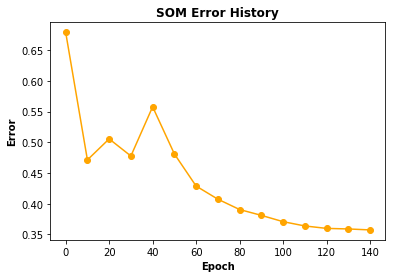

In [52]:
som.plot_error_history()

Now I visualize the learned representation with the group labels:

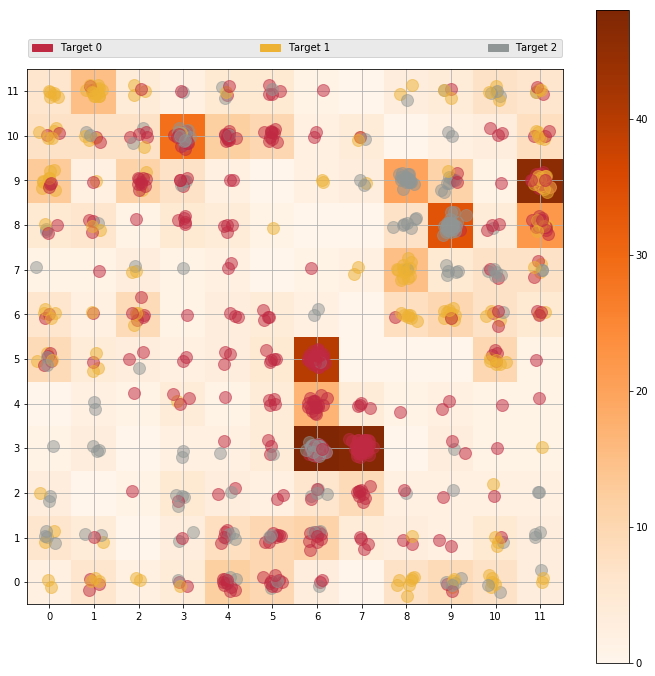

In [53]:
som.plot_point_map(data, target, ['Target 0', 'Target 1', 'Target 2'])

And finally visualize the map of every neuron and its distances to all neighbors based on the neuron weights:

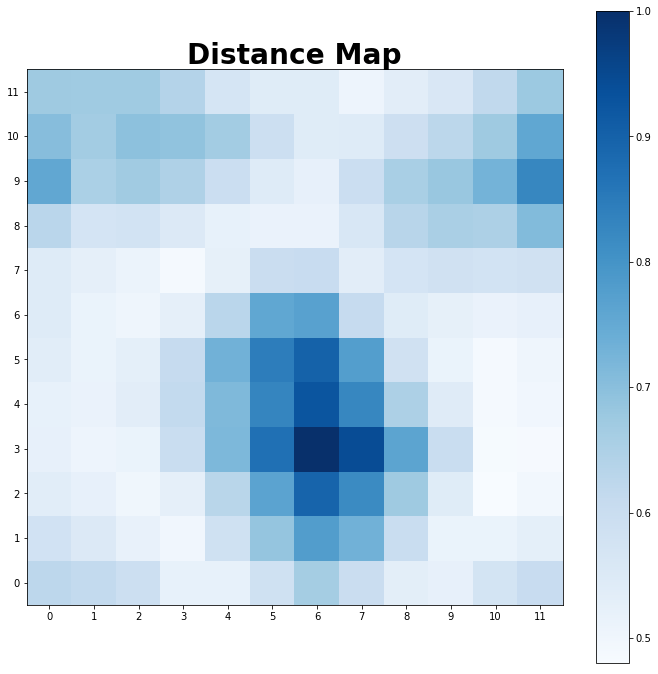

In [54]:
som.plot_distance_map(colormap='Blues')

SOMs can be used for:
- Dimensionality reduction
- Clustering
- Fraud detection using the Distance Map: for example, all the rows contained in the cluster with the coordinate (6,3) have a MID (Mean Interneuron Distance) very high. This means that are far away from the normal behaviour and, for certain application, we might consider these as fraud.
    
For semplicity, I decided to use PCA to reduce the dimensions of the input space. Let's check the number of components needed for PCA to explain 95% of the variance:

6 Principal Components are needed to exaplin 95% of the variance


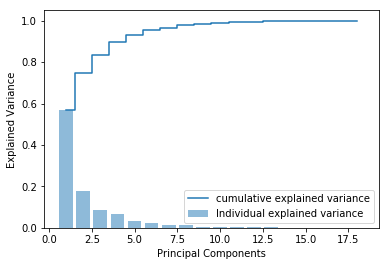

In [56]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
cum_var_exp = cumsum[cumsum<0.95]
plt.step(range(1, cumsum.shape[0]+1), cumsum, where= 'mid', label='cumulative explained variance')
plt.bar(range(1, cumsum.shape[0]+1), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
print('%d Principal Components are needed to exaplin 95%% of the variance' %d)
plt.show()

Applying the PCA with 6 Principal Components to the training and test set:

In [57]:
pca = PCA(n_components = d)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Tuning the hyperparameters using SVM model on the reduced dataset after PCA:

In [58]:
param_dist = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'C': np.linspace(0.1,10,100),
              'gamma': np.linspace(0.1,10,100)}
tuning(SVC(decision_function_shape='ovo', random_state=1), param_dist, X_train=X_train_pca)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Expected execution time is about 0:00:41.176210 

Execution time = 0:02:35.947551 

The best combination of hyperparameters is:

 {'kernel': 'rbf', 'gamma': 3.2, 'C': 4.3}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Saving SVM hyperparameters on the PCA dataset:

In [59]:
svm_pca_hyperparameters = {'kernel': 'rbf', 
                           'gamma': 3.2, 
                           'C': 4.3}

svm_pca = SVC(kernel=svm_pca_hyperparameters.get('kernel'),
              C=svm_pca_hyperparameters.get('C'),
              gamma=svm_pca_hyperparameters.get('gamma'),
              decision_function_shape='ovo',
              random_state=1)

Now I can calculate the accuracy using the SVM on the dataset reduced by using PCA:

              precision    recall  f1-score   support

     class 0       0.89      0.91      0.90       129
     class 1       0.77      0.85      0.81        60
     class 2       0.91      0.80      0.85        65

   micro avg       0.87      0.87      0.87       254
   macro avg       0.86      0.85      0.85       254
weighted avg       0.87      0.87      0.87       254



ACCURACY = 86.6 %


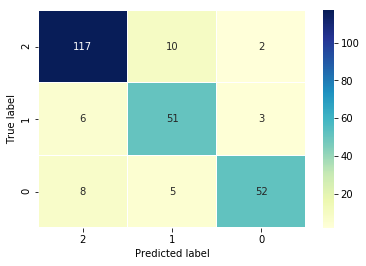

In [60]:
svm_pca.fit(X_train_pca, y_train)
y_pred = svm_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1', 'class 2']))
a = round(metrics.accuracy_score(y_test, y_pred),3)
print('\n\nACCURACY =',a*100,'%')
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True,  
            fmt='.0f', 
            xticklabels=["2", "1", "0"] , 
            yticklabels=["2", "1", "0"], 
            linewidths=0.1, 
            linecolor='white',
            cmap='YlGnBu')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The PCA didn't help at all for both performance and execution time.

Models performance range at 95% confidence level using the entire dataset with SVM and Light GBM:



SVM
Execution Time = 0:00:00.060608 
I am 95% confident that the accuracy of the model in production will be between 0.937 and 0.984


Light GBM
Execution Time = 0:00:00.060685 
I am 95% confident that the accuracy of the model in production will be between 0.941 and 0.984


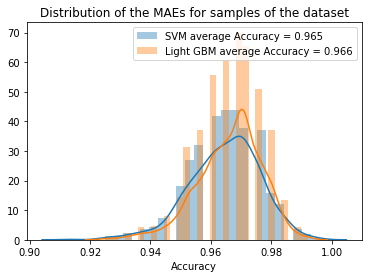

In [62]:
iterations = 1000

ACCs_lgbm = []
execution_time_lgbm = []
ACCs_svm = []
execution_time_svm = []

for i in range(1,iterations):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=i)
    for train_index, test_index in split.split(df, df['Target']):
        train = df.loc[train_index]
        test = df.loc[test_index]
        
    X_train = train.drop(['Target'],axis=1)
    X_test = test.drop(['Target'],axis=1)
    y_train = train['Target']
    y_test = test['Target']
    
    start=datetime.now()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    ACC_svm = round(metrics.accuracy_score(y_test, y_pred),3)
    ACCs_svm.append(ACC_svm)
    stop=datetime.now()
    execution_time = stop-start
    execution_time_svm.append(execution_time)
    
    start=datetime.now()
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    ACC_lgbm = round(metrics.accuracy_score(y_test, y_pred),3)
    ACCs_lgbm.append(ACC_lgbm)
    stop=datetime.now()
    execution_time = stop-start
    execution_time_lgbm.append(execution_time)

sns.distplot(ACCs_svm, kde=True, label='SVM average Accuracy = %0.3f' % (sum(ACCs_svm)/float(len(ACCs_svm)))).set_title('Distribution of the MAEs for samples of the dataset')
sns.distplot(ACCs_lgbm, kde=True, label='Light GBM average Accuracy = %0.3f' % (sum(ACCs_lgbm)/float(len(ACCs_lgbm)))).set_title('Distribution of the MAEs for samples of the dataset')
plt.xlabel('Accuracy')
plt.legend(loc = 'best')
alpha = 0.95                          
p = 100*((1.0-alpha)/2.0)   

total = execution_time_svm[0]
for i in range (1,len(execution_time_lgbm)):
    total = total + execution_time_lgbm[i]
avg_execution_time_svm = total/len(execution_time_lgbm)
lower = max(0.0, np.percentile(ACCs_svm, p))  
upper = max(0.0, np.percentile(ACCs_svm, 100-p))
print('\n\nSVM\nExecution Time = %s \nI am %.0f%% confident that the accuracy of the model in production will be between %.3f and %.3f\n' % (avg_execution_time_svm, alpha*100, lower, upper))

total = execution_time_lgbm[0]
for i in range (1,len(execution_time_lgbm)):
    total = total + execution_time_lgbm[i]
avg_execution_time_lgbm = total/len(execution_time_lgbm)
lower = max(0.0, np.percentile(ACCs_lgbm, p))  
upper = max(0.0, np.percentile(ACCs_lgbm, 100-p))
print('\nLight GBM\nExecution Time = %s \nI am %.0f%% confident that the accuracy of the model in production will be between %.3f and %.3f' % (avg_execution_time_lgbm, alpha*100, lower, upper))

Light GBM performed a bit better with a slightly smaller variance compared to SVM, with a similar average execution time.